In [154]:
import pandas as pd
import dateparser
from bs4 import BeautifulSoup


In [257]:
import re
import time
import requests
import datetime
import unicodedata
import unidecode
import dateutil.parser
from random import randint
from retry_decorator import retry





class GooglePage:
    def __init__(self, soup:str, query_id:int, start:int):
        self.soup = soup
        self.date_crawled = datetime.datetime.today()
        self.counter = 0
        self.query_id = query_id
        self.start = start

    @property
    def query(self):
        title = self.soup.title
        if title is not None:
            text = title.get_text().split('- ')[:-1]
            query = ''.join(text)
            return query

    @property
    def results_count(self):
        stats = self.soup.find('div', id='resultStats')
        if stats is not None:
            text = stats.get_text().strip()
            m = re.findall(r'((?:\d+[,\.])*\d+)', text)
            text = m[0].replace(",", "").replace('.', '')
            text = unicodedata.normalize("NFKD", text)
            results_count = int(text)
            return results_count

    @property
    def results_containers(self):
        container = self.soup.find('div', id='search')
        if container is not None:
            result_containers = container.find_all("g-card")
            return result_containers

    @property
    def image_script(self):
        scripts = self.soup.find_all('script')
        image_scripts = [x for x in scripts if x.get_text().startswith('function _setImagesSrc')]
        if len(image_scripts) == 1:
            image_script = image_scripts[0].get_text()
            return image_script

    @property
    def data_images(self):
        image_script = self.image_script
        if image_script:
            data_images = GooglePage.find_images_in_script(image_script)
            return data_images

    @property
    def next_page(self):
        try:
            anchor = self.soup.find("a", {"id": "pnnext"})
            link = anchor.get("href")
            splitted = link.split("?")[1].split("&")
            start_param = [x for x in splitted if "start" in x][0]
            start = start_param.split("=")[1]
            return start
            
        except Exception as e:
            print(e)

    def results(self):
        query = self.query
        query_id = self.query_id
        date_crawled = self.date_crawled
        for i, result_soup in enumerate(self.results_containers):
            search_position = str(i+1+self.start)
            yield GoogleResult(result_soup, search_position=search_position, query=query, query_id=query_id, date_crawled=date_crawled).parse()

    def videos(self):
        video_heading = self.soup.find_all(lambda x: x.name == "h3" and x.get_text() == "Videos")
        if video_heading:
            return video_heading[0].parent.parent

class VideoResult:
    def __init__(self, soup):
        return
        
            
class GoogleResult:
    def __init__(self, soup, search_position=None, query=None, query_id=None, date_crawled=None, data_images=None):
        self.soup = soup
        self.search_position = search_position
        self.query = query
        self.query_id = query_id
        self.date_crawled = date_crawled
        self.data_images = data_images

    @property
    def id(self):
        if self.query_id:
            id_ = "{}{}{}".format(int(self.date_crawled.timestamp()), self.query_id, self.search_position)  # Should be unique with single thread
            return id_

    @property
    def title(self):
        title_ = self.soup.find('h3') or self.soup.find("div", {'role': 'heading'})
        if title_ is not None:
            title = title_.get_text().strip()
            title = unicodedata.normalize("NFKD", title)
            return title

    @property
    def link(self):
        div = self.soup.find('div', class_='r')
        if div is not None:
            link = div.a.get('href')
            if link.startswith('/url?'):
                link = link.split('/url?q=')[1]

        anchor = self.soup.find("a", {"style": "text-decoration:none;display:block"}) #news result
        if anchor is not None:
            link = anchor.get("href")

        return link

    @property
    def website(self):
        citation = self.soup.find("cite")
        if citation:
            website = citation.get_text().split("›")[0]
            return website

        images = self.soup.find_all("g-img")
        if len(images) == 2:
            website = images[1].parent.get_text()
            return website
        

    @property
    def description(self):
        description_ = self.soup.find('span', class_='st')
        
        sibling = self.soup.find("div", {"role": "heading"})
        if sibling is not None:
            description_ = list(sibling.parent.children)[-1]

        if description_:
            description = description_.get_text()
            description = unicodedata.normalize("NFKD", description)
            return description

    @property
    def keywords_matched(self):
        description_text = self.soup.find('span', class_='st')
        if description_text:
            keywords_matched = description_text.find_all('em')
            keywords_matched = list(set([x.get_text().lower() for x in keywords_matched]))
            return keywords_matched

    @property
    def image(self):
        parent = self.soup.find("g-img")
        if parent:
            image = parent.img.get("src")
            return image

    @property
    def date(self):
        spans = self.soup.find_all("span")
        if len(spans) > 0:
            date_description = spans[-1].get_text()
            try: 
                date = GoogleResult.format_date(date_description)
                return date
            except Exception as e:
                print(e)
            

    @staticmethod
    def clean_text(text):
        if text is not None and isinstance(text, str):
            cleaned = ' '.join(unidecode.unidecode(text).split()).strip()
            return cleaned
        return text

    @staticmethod
    def format_date(x: str) -> str:
        try:
            parsed = dateparser.parse(x, languages=["de"])
            formatted = parsed.strftime("%d/%m/%Y %H:%M")
            return formatted

        except Exception as e:
            print(e, x)
            try:
                parsed = time.strptime(x, "%d.%m.%Y")
                formatted = time.strftime("%d/%m/%Y %H:%M", parsed)
                return formatted
                
            except Exception as e:
                print(e)

        return x
        

    def parse(self):
        data = {
            'id': self.id,
            'title': self.title,
            'link': self.link,
            'website': self.website,
            'description': self.description,
            'search_position': self.search_position,
            'query': self.query,
            'query_id': self.query_id,
            'keywords_matched': self.keywords_matched,
            "image": self.image,
            "date": self.date,
            'date_crawled': self.date_crawled,
        }

        for k, v in data.items():
            data[k] = GoogleResult.clean_text(v)

        return data

    @staticmethod
    def date_text_to_datetime(text):
        if '-' in text:
            text = text.split('- ')[1]
        if 'ago' in text:
            amount, measure = text.replace(' ago', '').split()
            if not measure.endswith('s'):
                measure += 's'
            delta = {measure: int(amount)}
            date_published = datetime.datetime.today() - datetime.timedelta(**delta)
        else:
            date_published = dateutil.parser.parse(text)
        return date_published


class GoogleSearch:
    '''
        Geolocation: aa
        HL: https://sites.google.com/site/tomihasa/google-language-codes
    '''

    def __init__(self, params):
        self.params = params
        self.urls = ['http://www.google.com/search', 'https://www.google.com/search']
        self.headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.106 Safari/537.36'}
        self.counter = 0

    @retry(RateLimitError, tries=5, timeout_secs=60)
    def get_html(self, query):
        counter = self.counter % 2
        url = self.urls[counter]
        headers = self.headers #[counter]
        params = self.params.copy()
        params.update({'q': query})
        response = requests.get(url, params=params, headers=headers)
        print('\t', response.url)
        status_code = response.status_code
        print('\t', self.counter, status_code, url, headers)

        if response.ok:
            return response.text
        else:
            self.counter += 1
            if status_code == 429:
                raise RateLimitError('Ratelimit surpassed')
            else:
                raise Exception('Forbidden')

In [258]:
def get_all_data(query: str, params: dict, query_id: int, dump=False) -> list:
    start = 0
    params.update({"start": start})

    data = []
    while True:
        data_ = get_data(query, params, query_id)
        if data_:
            if dump == True:
                start = params.get("start")
                file_path = f"./{query_id}_{start}.html"
                with open(file_path, "wb") as f:
                    f.write(html.encode("utf8"))

            start += 100
            params.update({"start": start})
            data.extend(data_)
        else:
            break
    
    return data

In [259]:
def get_data(query: str, params: dict, query_id: int) -> list:
    google_search = GoogleSearch(params)
    html = google_search.get_html(query)
    soup = BeautifulSoup(html, features="html.parser")
    start = params.get('start')
    # print("page", page)a
    google_page = GooglePage(soup, query_id=query_id, start=start)
    data = list(google_page.results())
    return data

In [260]:
data = get_all_data(query, params, query_id, dump=True)

	 https://www.google.com/search?tbm=nws&hl=de&gl=DE&num=100&start=0&q=Netflix+Dark&gws_rd=ssl
	 0 200 http://www.google.com/search {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.106 Safari/537.36'}
	 https://www.google.com/search?tbm=nws&hl=de&gl=DE&num=100&start=100&q=Netflix+Dark&gws_rd=ssl
	 0 200 http://www.google.com/search {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.106 Safari/537.36'}
	 https://www.google.com/search?tbm=nws&hl=de&gl=DE&num=100&start=200&q=Netflix+Dark&gws_rd=ssl
	 0 200 http://www.google.com/search {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.106 Safari/537.36'}
	 https://www.google.com/search?tbm=nws&hl=de&gl=DE&num=100&start=300&q=Netflix+Dark&gws_rd=ssl
	 0 200 http://www.google.com/search {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac 

In [261]:
df = pd.DataFrame(data)
df.to_csv("~/Desktop/Netflix Dark.csv", index=False)
print(df.shape)
df.head()


(241, 12)


,id,title,link,website,description,search_position,query,query_id,keywords_matched,image,date,date_crawled
0,161589548311,Dystopie aus Deutschland: Das ist das neue Net...,https://www.kino.de/serie/tribes-of-europa/new...,KINO.DE,"Nach den erfolgreichen Serien ,,Dark"", ,,How t...",1,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",23/02/2021 11:51,2021-03-16 11:51:23.106473
1,161589548312,"Jetzt neu auf Netflix: Ein Nolan-Meisterwerk, ...",http://www.filmstarts.de/nachrichten/18534623....,filmstarts,"Mit ,,Tribes Of Europa"" bietet Netflix heute a...",2,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",23/02/2021 11:51,2021-03-16 11:51:23.106473
2,161589548313,"Hat ""Tribes Of Europa"" das Zeug zum neuen ""Dar...",http://www.filmstarts.de/nachrichten/18534616....,filmstarts,"Wir haben die komplette erste Staffel von ,,Tr...",3,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",23/02/2021 11:51,2021-03-16 11:51:23.106473
3,161589548314,Netflix: Diese funf deutschen Serien wurden am...,https://www.tz.de/leben/serien/netflix-deutsch...,tz.de,"Die Netflix-Serie ,,Dark"" erhielt besonders po...",4,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",23/02/2021 11:51,2021-03-16 11:51:23.106473
4,161589548315,"""Terminator""-Reihe geht bei Netflix weiter - a...",http://www.filmstarts.de/nachrichten/18534741....,filmstarts,"Nachdem ,,Terminator 6: Dark Fate"" nicht die E...",5,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",02/03/2021 11:51,2021-03-16 11:51:23.106473


In [263]:
df.head(1)

,id,title,link,website,description,search_position,query,query_id,keywords_matched,image,date,date_crawled
0,161589548311,Dystopie aus Deutschland: Das ist das neue Net...,https://www.kino.de/serie/tribes-of-europa/new...,KINO.DE,"Nach den erfolgreichen Serien ,,Dark"", ,,How t...",1,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",23/02/2021 11:51,2021-03-16 11:51:23.106473


## Analysis

In [273]:
!pip install langdetect

You should consider upgrading via the '/Users/chris.daly/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [274]:
from matplotlib import pyplot as plt
import langdetect

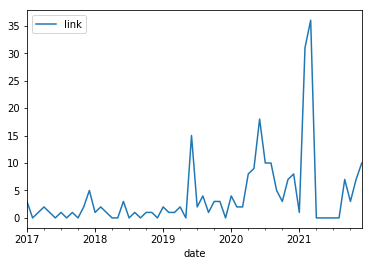

In [271]:
df["date"] = pd.to_datetime(df["date"])
df[["date", "link"]].set_index("date").groupby(pd.Grouper(freq='M')).count().plot()
plt.show()

In [278]:
df["language"] = df["title"].apply(langdetect.detect)

In [279]:
df

,id,title,link,website,description,search_position,query,query_id,keywords_matched,image,date,date_crawled,language
0,161589548311,Dystopie aus Deutschland: Das ist das neue Net...,https://www.kino.de/serie/tribes-of-europa/new...,KINO.DE,"Nach den erfolgreichen Serien ,,Dark"", ,,How t...",1,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-02-23 11:51:00,2021-03-16 11:51:23.106473,de
1,161589548312,"Jetzt neu auf Netflix: Ein Nolan-Meisterwerk, ...",http://www.filmstarts.de/nachrichten/18534623....,filmstarts,"Mit ,,Tribes Of Europa"" bietet Netflix heute a...",2,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-02-23 11:51:00,2021-03-16 11:51:23.106473,de
2,161589548313,"Hat ""Tribes Of Europa"" das Zeug zum neuen ""Dar...",http://www.filmstarts.de/nachrichten/18534616....,filmstarts,"Wir haben die komplette erste Staffel von ,,Tr...",3,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-02-23 11:51:00,2021-03-16 11:51:23.106473,de
3,161589548314,Netflix: Diese funf deutschen Serien wurden am...,https://www.tz.de/leben/serien/netflix-deutsch...,tz.de,"Die Netflix-Serie ,,Dark"" erhielt besonders po...",4,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-02-23 11:51:00,2021-03-16 11:51:23.106473,de
4,161589548315,"""Terminator""-Reihe geht bei Netflix weiter - a...",http://www.filmstarts.de/nachrichten/18534741....,filmstarts,"Nachdem ,,Terminator 6: Dark Fate"" nicht die E...",5,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-02-03 11:51:00,2021-03-16 11:51:23.106473,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,16158954841237,VIDEO: Watch the New Trailer for THE IRREGULAR...,https://www.broadwayworld.com/bwwtv/article/VI...,Broadway World,As the crimes take on a horrifying supernatura...,237,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-03-15 14:51:00,2021-03-16 11:51:24.892779,en
237,16158954841238,WandaVision bis Avatar: Hort den Moviepilot-Po...,https://www.moviepilot.de/news/streamgestober-...,MOVIEPILOT NEWS,Wir knopfen uns im Podcast Streamgestober in w...,238,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2019-10-23 00:00:00,2021-03-16 11:51:24.892779,de
238,16158954841239,Decision On Kadmon's Belumosudil US Applicatio...,https://www.benzinga.com/general/biotech/21/03...,None,Benzinga's Breakout trader is already up over ...,239,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-12-03 11:51:00,2021-03-16 11:51:24.892779,en
239,16158954841240,12 Health Care Stocks Moving In Thursday's Aft...,https://www.benzinga.com/general/health-care/2...,None,Benzinga's Breakout trader is already up over ...,240,Netflix Dark,1,None,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",2021-12-03 11:51:00,2021-03-16 11:51:24.892779,en
